### Diabetes bei Pima-Indianern

In [1]:
# first neural network with keras make predictions
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

Daten vorbereiten

In [2]:
# load pima indians dataset
import numpy as np
dataset = np.loadtxt("pima-indians-diabetes.csv", delimiter=",")
# split into input (X) and output (Y) variables
X = dataset[:,0:8]
Y = dataset[:,8]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5)

Modell bauen und trainieren

In [4]:
# create model
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                108       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Fit the model
history = model.fit(X_train, y_train, validation_split=0.33, epochs=150, batch_size=10, verbose=1)

Epoch 1/150
26/26 [==============================] - 1s 6ms/step - loss: 8.9641 - accuracy: 0.6265 - val_loss: 5.6743 - val_accuracy: 0.6378
Epoch 2/150
26/26 [==============================] - 0s 2ms/step - loss: 3.8024 - accuracy: 0.5681 - val_loss: 2.1600 - val_accuracy: 0.5118
Epoch 3/150
26/26 [==============================] - 0s 2ms/step - loss: 1.9485 - accuracy: 0.5058 - val_loss: 1.4352 - val_accuracy: 0.5197
Epoch 4/150
26/26 [==============================] - 0s 2ms/step - loss: 1.5562 - accuracy: 0.5759 - val_loss: 1.1717 - val_accuracy: 0.4961
Epoch 5/150
26/26 [==============================] - 0s 2ms/step - loss: 1.3941 - accuracy: 0.5642 - val_loss: 1.1220 - val_accuracy: 0.5433
Epoch 6/150
26/26 [==============================] - 0s 2ms/step - loss: 1.2400 - accuracy: 0.6070 - val_loss: 1.0541 - val_accuracy: 0.5512
Epoch 7/150
26/26 [==============================] - 0s 2ms/step - loss: 1.1398 - accuracy: 0.6226 - val_loss: 1.0201 - val_accuracy: 0.5591
Epoch 8/150
2

Beispielhafte Prädiktionen

In [6]:
#make class predictions with the model
threshold = 0.5   # determines diabetes or not
y_pred_class = (model.predict(X_test) > threshold).astype(int)
# summarize the first 5 cases
for i in range(5):
	print('%s => %d (expected %d)' % (X[i].tolist(), y_pred_class[i], y_test[i]))

[6.0, 148.0, 72.0, 35.0, 0.0, 33.6, 0.627, 50.0] => 0 (expected 0)
[1.0, 85.0, 66.0, 29.0, 0.0, 26.6, 0.351, 31.0] => 0 (expected 1)
[8.0, 183.0, 64.0, 0.0, 0.0, 23.3, 0.672, 32.0] => 1 (expected 1)
[1.0, 89.0, 66.0, 23.0, 94.0, 28.1, 0.167, 21.0] => 0 (expected 0)
[0.0, 137.0, 40.0, 35.0, 168.0, 43.1, 2.288, 33.0] => 1 (expected 0)


Trainingsstatistik anzeigen

In [7]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


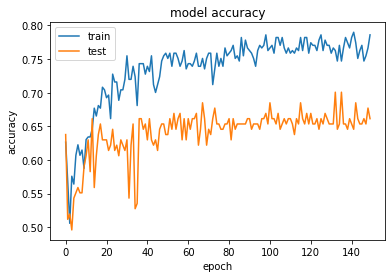

In [8]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

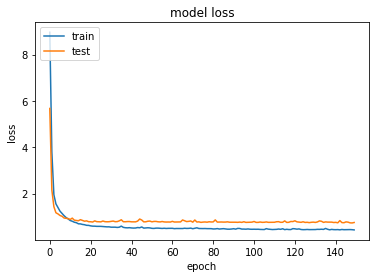

In [9]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Evaluation

In [10]:
# evaluate the keras model
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

12/12 [==============================] - 0s 910us/step - loss: 0.6372 - accuracy: 0.6771
Accuracy: 67.71


__ROC-Kurve__ 

In [11]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [12]:
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds_keras = roc_curve(y_test, y_pred)
auc_roc = auc(fpr, tpr)

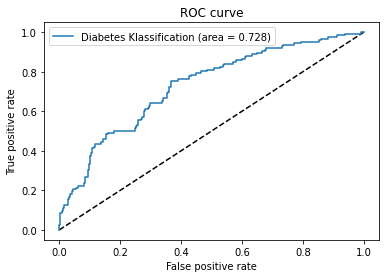

In [13]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Diabetes Klassification (area = {:.3f})'.format(auc_roc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

__Optimaler Schwellwert__ 

Optimal ist der Punkt auf der ROC-Kurve möglichst weit oben und links, d.h. mit kleinster euklidscher Distanz zur linken, oberen Ecke.

$ d(tpr, fpr) = \sqrt{({tpr_1 - tpr_2})^{2} + {fpr_1 - fpr_2})^{2}} $

_Hinweis_: zip nimmt mehrere Iteratoren und verknüpft diese zu Tupeln. 'sorted' sortiert nach erster Komponente der Tupel absteigend (reverse=true).


In [14]:
optimal_proba_cutoff = sorted(list(zip(np.abs(tpr - fpr), thresholds_keras)), key=lambda i: i[0], reverse=True)[0][1]
optimal_proba_cutoff

0.35327077

__Precision-Recall-Kurve__

In [15]:
num_0 = len(y_train==0)
num_1 = len(y_train==1)
print(f'Diabetes: {num_0}  Kein Diabetes: {num_1}')

Diabetes: 384  Kein Diabetes: 384


In [16]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

In [17]:
# calculate precision and recall for each threshold
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_prc = auc(recall, precision)

In [18]:
# calculate scores
f1 = f1_score(y_test, y_pred_class)
f1

0.5338345864661653

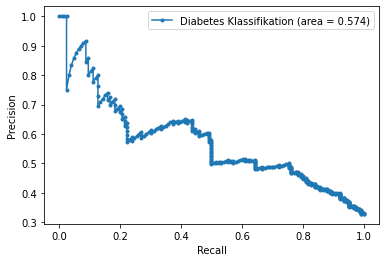

In [19]:
plt.plot(recall, precision, marker='.', label='Diabetes Klassifikation (area = {:.3f})'.format(auc_prc))
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()